To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Qwen2 VL 7B to convert handwritten math formulas into machine readable LaTeX form.**

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

!pip install python-dotenv
# Load environment variables from .env file
load_dotenv()
'Done'

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [11]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    # "unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit",
    # "HuggingFaceTB/SmolVLM-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

<ipython-input-11-7d2fea0e4e8e>:1: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel # FastLanguageModel for LLMs


TypeError: must be called with a dataclass type or instance

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [9]:
from unsloth_zoo.peft_utils import get_peft_regex

all_trainable_modules = get_peft_regex(
                    model,
                finetune_vision_layers     = True,
                finetune_language_layers   = True,
                finetune_attention_modules = True,
                finetune_mlp_modules       = True,

)

all_trainable_modules

'(?:.*?(?:vision|image|visual|patch|language|text).*?(?:self_attn|attention|attn|mlp|feed_forward|ffn|dense).*?(?:k_proj|v_proj|q_proj|out_proj|fc1|fc2|o_proj|gate_proj|up_proj|down_proj).*?)|(?:\\bmodel\\.layers\\.[\\d]{1,}\\.(?:self_attn|attention|attn|mlp|feed_forward|ffn|dense)\\.(?:(?:k_proj|v_proj|q_proj|out_proj|fc1|fc2|o_proj|gate_proj|up_proj|down_proj)))'

In [ ]:
# https://docs.unsloth.ai/basics/lora-parameters-encyclopedia

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # None And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
    # target_modules=["q_proj", "v_proj"]
)
'Done'

In [3]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
percentage_trainable = (trainable_params / total_params) * 100

print(f"Total parameters: {total_params:_d}")
print(f"Trainable parameters: {trainable_params:_d}")
print(f"Percentage of trainable parameters: {percentage_trainable:.2f}%")


NameError: name 'model' is not defined

<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [ ]:
from datasets import load_dataset
from huggingface_hub import login
import os

login(os.getenv("HF_API_KEY"))

In [8]:
dataset = load_dataset("Tami3/HazardQA-Reasoning")

README.md:   0%|          | 0.00/733 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/72.8M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/79.8M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/75.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4985 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1065 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1075 [00:00<?, ? examples/s]

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'category_topic', 'question', 'chain_of_thought', 'answer'],
        num_rows: 4985
    })
    validation: Dataset({
        features: ['image', 'image_id', 'category_topic', 'question', 'chain_of_thought', 'answer'],
        num_rows: 1065
    })
    test: Dataset({
        features: ['image', 'image_id', 'category_topic', 'question', 'chain_of_thought', 'answer'],
        num_rows: 1075
    })
})

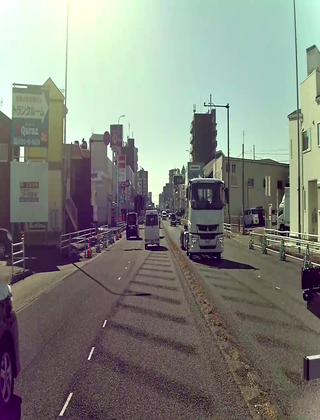

Are the vehicles likely in compliance with traffic rules?

Given the orderly lane positioning and spacing, it suggests that the vehicles are adhering to traffic regulations, indicating compliance.
Yes, the vehicles appear to be in compliance.


In [10]:
from IPython.display import display

val_dataset = dataset['validation']

display(val_dataset[2]["image"])
print(val_dataset[2]["question"])
print()
print(val_dataset[2]["chain_of_thought"])
print(val_dataset[2]["answer"])

In [12]:
system_prompt = """You are an AI assistant specialized in analyzing scenes captured from an ego car's dashcam and other sensors. Your role is to provide detailed and accurate descriptions of the environment surrounding the ego car, including but not limited to, the presence of other vehicles, pedestrians, traffic signs, road conditions, and any other relevant objects or events. You should also be able to answer queries related to the scene, such as the distance between the ego car and other objects, the speed of surrounding vehicles, and the likelihood of potential hazards. Your responses should be clear, concise, and based on the data provided in the scene. If you are unsure about a specific detail, please indicate that you cannot provide an exact answer but will do your best to estimate based on the available information."""
cot_system_prompt = """You are an AI assistant specialized in analyzing scenes captured from an ego car's dashcam and other sensors. Your role is to provide detailed and accurate descriptions of the environment surrounding the ego car, including but not limited to, the presence of other vehicles, pedestrians, traffic signs, road conditions, and any other relevant objects or events. When answering user queries, please include your reasoning process (chain of thought) to show how you arrived at your conclusions. This should include any assumptions you make, the data you are considering, and how you are interpreting the scene. Your responses should be clear, concise, and based on the data provided in the scene. If you are unsure about a specific detail, please indicate that you cannot provide an exact answer but will do your best to estimate based on the available information"""

In [13]:

def convert_to_conversation(sample):
    conversation = [
        # {
        #     "role": "system",
        #     "content": [
        #         {"type": "text", "text": system_prompt}
        #     ]
        # },
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : sample['question']},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : f"**Thinking** {sample['chain_of_thought']} ***Final Answer** {sample['answer']}"} 
          ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [14]:
from tqdm import tqdm

train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']


converted_train_dataset = [convert_to_conversation(sample) for sample in tqdm(train_dataset)]
converted_val_dataset = [convert_to_conversation(sample) for sample in tqdm(val_dataset)]
converted_test_dataset = [convert_to_conversation(sample) for sample in tqdm(val_dataset)]

100%|██████████| 1065/1065 [00:05<00:00, 191.26it/s]


We look at how the conversations are structured for the first example:

In [15]:
converted_train_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Are there any visible traffic signs or signals in the scene?'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x420>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '**Thinking** The image shows various signs along the street, which likely indicate regulations for drivers and pedestrians. ***Final Answer** Yes, there are several signs along the street.'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

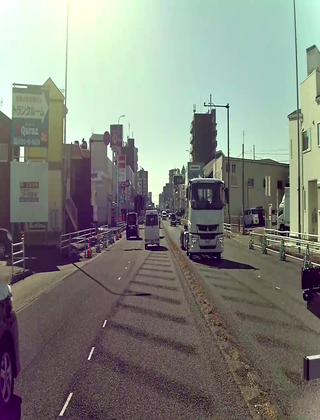

Are the vehicles likely in compliance with traffic rules?

Yes, the vehicles appear to be in compliance with traffic rules. The truck is driving on the right side of the road, which is the standard for right-hand traffic in many countries. Additionally, the truck is following the lane markings and appears to be moving at a safe speed.<|im_end|>


In [23]:
from IPython.display import display

FastVisionModel.for_inference(model) # Enable for inference!

image = val_dataset[2]["image"]
instruction = val_dataset[2]['question']

display(image)
print(instruction)
print()

messages = [
    # {"role": "system", "content": [
    #     {"type": "text", "text": system_prompt}
    # ]},
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
               use_cache = True, temperature = 1.5, min_p = 0.1)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [35]:
# from unsloth import is_bf16_supported
# from trl import SFTConfig

# output_dir = 'HazardNet-unsolth'

training_args = SFTConfig(
    output_dir=output_dir,  # Directory to save the model
    num_train_epochs=1,  # Number of training epochs
    # warmup_steps = 5,
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="linear",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=1,  # Steps interval for logging
    eval_steps=20,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=40,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    # bf16=True,  # Use bfloat16 precision
    # tf32=True,  # Use TensorFloat-32 precision
    fp16 = not is_bf16_supported(),
    bf16 = is_bf16_supported(),
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    max_seq_length=1024  # Maximum sequence length for input
)

In [24]:
from trl import SFTConfig
from unsloth import is_bf16_supported

output_dir = 'HazardNet-3B'

training_args = SFTConfig(
    output_dir = output_dir,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size= 8,
    gradient_accumulation_steps = 4,
    # warmup_steps = 5,
    warmup_ratio=0.02,
    max_steps = 100,
    # num_train_epochs = 1, # Set this instead of max_steps for full training runs
    eval_steps=20,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=100,
    learning_rate = 2e-4,
    fp16 = not is_bf16_supported(),
    bf16 = is_bf16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear", #"linear",
    seed = 3407,
    # push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics

    load_best_model_at_end=True,
    # You MUST put the below items for vision finetuning:
    remove_unused_columns = False,
    dataset_text_field = "",
    dataset_kwargs = {"skip_prepare_dataset": True},
    dataset_num_proc = 4,
    max_seq_length = 2048,
)


In [25]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

wandb.login(key=WANDB_API_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mabutame. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [137]:
# wandb.finish()

In [26]:
import wandb
from datetime import datetime

now = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

wandb.init(
    project="HazardNet",  # change this
    name=f"{output_dir}-{now}",  # change this
    config=training_args,
)

In [27]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    args=training_args,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_train_dataset,
    eval_dataset=converted_val_dataset[:500],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Unsloth: Model does not have a default image size - using 512


In [28]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
9.258 GB of memory reserved.


In [29]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,985 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,084,928/3,000,000,000 (1.37% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,nan,0.826852
40,nan,0.655285
60,nan,0.615654
80,nan,0.595631
100,nan,0.586688


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=100, training_loss=nan, metrics={'train_runtime': 2456.8152, 'train_samples_per_second': 0.651, 'train_steps_per_second': 0.041, 'total_flos': 8338901610381312.0, 'train_loss': nan})

In [54]:
# trainer.push_to_hub(output_dir)

  0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Tami3/HazardNet-reasoning-v0.2/commit/0df7b9dc7ad9782143ddb9f7d79beb145f2ed7a5', commit_message='HazardNet-reasoning-v0.2', commit_description='', oid='0df7b9dc7ad9782143ddb9f7d79beb145f2ed7a5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Tami3/HazardNet-reasoning-v0.2', endpoint='https://huggingface.co', repo_type='model', repo_id='Tami3/HazardNet-reasoning-v0.2'), pr_revision=None, pr_num=None)

In [55]:
wandb.finish()

eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁▁
train/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▇▇█▇▅▂▁▁▂▂▁▂▃▄▄▂▂▄▁▁▁▁▂▁▁▁▃▃▁▂▃▂▄▃▄▂▄▂▂▂
train/learning_rate,███▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▇▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▁▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▂▁▁▁▂▂▁
eval/loss,0.93324
eval/runtime,75.928


In [58]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
# print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Peak reserved memory = 9.73 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 66.006 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

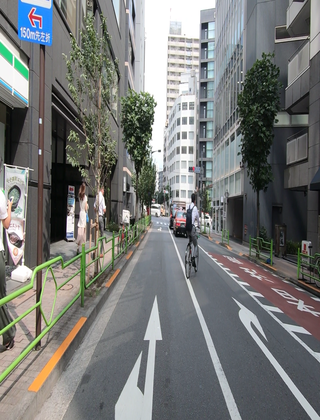

How is the bicycle positioned relative to the car?
The bicycle is in a dedicated lane to the left of the car, indicating that it has its own space separate from the vehicle traffic. This positioning is important for safety.: The bicycle is in a dedicated lane to the left of the car.

***Thinking** The bicycle is in the foreground, while the car is behind it, indicating that the cyclist is likely moving ahead of the vehicle. ***Final Answer** The bicycle is in front of the car.<|im_end|>


In [30]:
FastVisionModel.for_inference(model) # Enable for inference!

n = 500
image = val_dataset[n]["image"]
instruction = val_dataset[n]["question"]
cot = val_dataset[n]["chain_of_thought"]

answer = val_dataset[n]["answer"]

display(image)
print(instruction)
print(f"{cot}: {answer}")
print()

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 0.01, min_p = 0.1)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [31]:
# model.push_to_hub("Tami3/HazardNet-v0.1") # Online saving
# tokenizer.push_to_hub("Tami3/HazardNet-v0.1") # Online saving

# model.save_pretrained("lora_model") # Local saving
# tokenizer.save_pretrained("lora_model")
model.push_to_hub(f"Tami3/{output_dir}") # Online saving
tokenizer.push_to_hub(f"Tami3/{output_dir}") # Online saving

README.md:   0%|          | 0.00/622 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/164M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Tami3/HazardNet-3B


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [5]:
from transformers import TextStreamer

class CapturingTextStreamer(TextStreamer):
    def __init__(self, tokenizer, **kwargs):
        super().__init__(tokenizer, **kwargs)
        self.generated_text = ""

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.generated_text += text
        super().on_finalized_text(text, stream_end=stream_end)


In [22]:
system_prompt = """
You are an advanced AI assistant specialized in analyzing driving scenes from images. Your task is to process the provided image and extract detailed information about the scene. Please perform the following steps:

1. **ChainOfThough**: Reasoning steps or thought process leading to the answer.

2. **Scene Classification**: Determine the overall type of the scene. Output one of: [Narrow lane, Intersection, Urban road].

3. **Agent Classification**: Identify agent present in the scene that might cause the risk. Output one of [N/A, Infrastructure, Pedestrian, Vehicle, Cyclist].

4. **Suggested Action**: Based on the analysis, recommend the most appropriate action for the ego vehicle to take, when Risk Assessment is No, then the Suggested Action is N/A . Output one of [N/A, Yield, Carefully Slow Down, Must Stop, Keep Moving].

5. **Risk Assessment**: Evaluate whether there is a potential risk in the current scene that requires immediate attention. Output one of [Yes, No]

**Response Instructions:**
in the **Final Answer**, response in xml format, Start the response **directly with the `<SceneAnalysis>` tag**. Do not add any explanations, headers, or labels like "XML" or "Output:". Do not add any descriptive text or explanations.

```xml
<SceneAnalysis>
    <ChainOfThough></ChainOfThough>
    <SceneClassification></SceneClassification>
    <AgentClassification></AgentClassification>
    <SuggestedAction></SuggestedAction>
    <IsThereRisk></IsThereRisk>
</SceneAnalysis>
```
"""


In [38]:
system_prompt = """
You are an advanced AI assistant specialized in analyzing driving scenes from images. Your task is to process the provided image and extract detailed information about the scene. Please perform the following steps:

1. **ChainOfThough**: Reasoning steps or thought process leading to the answer.

2. **Scene Classification**: Determine the overall type of the scene. Output one of: 
        i. Narrow lane
        ii. Intersection
        iii. Urban road

3. **Agent Classification**: Identify agent present in the scene that might cause the risk. Output one of:
        i. N/A
        ii. Infrastructure
        iii. Pedestrian
        iv. Vehicle
        v. Cyclist

4. **Suggested Action**: Based on the analysis, recommend the most appropriate action for the ego vehicle to take, when Risk Assessment is No, then the Suggested Action is N/A . Output one of:
        i. N/A
        ii. Yield
        iii. Carefully Slow Down
        iv. Must Stop
        v. Keep Moving

5. **Risk Assessment**: Evaluate whether there is a potential risk in the current scene that requires immediate attention. Output one of:
        i. Yes
        ii. No

Response in *JSON* format.

```json
{
    "SceneAnalysis": {
        "ChainOfThough": "..",
        "SceneClassification": "..",
        "AgentClassification": "..",
        "SuggestedAction": "..",
        "IsThereRisk": ".."
    }
}
```
"""


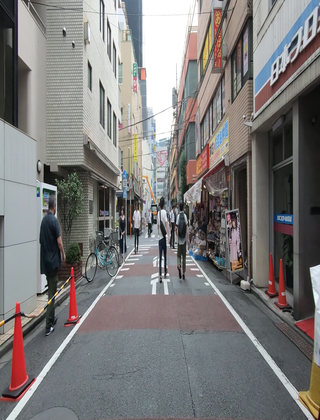


The scene depicts a narrow lane with pedestrians and a cyclist, indicating a potential for traffic congestion. **Final Answer** The scene is a narrow lane with pedestrians and a cyclist, indicating potential traffic congestion. **Analysis** The narrowness suggests a risk of congestion. **Action** Yield. **Risk Assessment** Yes.


In [39]:
output_dir = 'HazardNet-reasoning-v0.4'

if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = f"Tami3/{output_dir}", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

n = 3
image = test_dataset[n]["image"]
instruction = system_prompt # val_dataset[n]["question"]
cot = test_dataset[n]["chain_of_thought"]
answer = test_dataset[n]["answer"]

display(image)
# print(instruction)
# print(f"{cot}: {answer}")
print()

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True, skip_special_tokens=True)
text_streamer = CapturingTextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
outputs = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = False, temperature = 0.01, min_p = 0.1)

In [111]:
text_streamer.generated_text

'<SceneAnalysis>\n    <Caption>Street scene with a cyclist and urban infrastructure.</Caption>\n    <SceneClassification>Urban road</SceneClassification>\n    <DirectionOfEgoCar>Right</DirectionOfEgoCar>\n    <AgentClassification>Infrastructure</AgentClassification>\n    <SuggestedAction>Keep Moving</SuggestedAction>\n    <IsThereRisk>No</IsThereRisk>\n</SceneAnalysis>'

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [72]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if True: model.push_to_hub_merged("Tami3/HazardNet-unsloth-reasoning-v0.3", tokenizer)

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:19<00:00, 19.17s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>